In [ ]:
#Mounts your google drive into this virtual machine

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Now we need to access the files downloaded, copy the path where you saved the files downloaded from the github repo and replace the path below
%cd /content/drive/MyDrive/path/to/files/cloned/from/repo/and/now/in/your/GoogleDrive/


/content/drive/MyDrive/CogFlex


In [ ]:
!git clone https://github.com/paulvangentcom/heartrate_analysis_python.git
!pip install neurokit2
!pip install pandas==1.1.5
#Change the path below to the place to the directory that has the heartrate_analysis_python directory
%cd /content/drive/MyDrive/YOURPATH/heartrate_analysis_python

!python setup.py install

In [ ]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import matplotlib
import neurokit2 as nk
import matplotlib.pyplot as plt

import os
import heartpy as hp
import random
#from pylsl import StreamInfo,  StreamOutlet, resolve_stream, StreamInlet

from sklearn.cross_decomposition import CCA
from scipy import signal

from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq, ifft

import pickle

plt.rcParams['figure.figsize'] = [20, 15]

## **Offline PPG data visualization and processing**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/YOURPATH/SharedPublicly/Data/PPG-RAW-2021-09-03_12-03-27.txt',header=4 ,sep=r'\s*,\s*',engine='python')
data.columns = ["Sample Index",	"EMG Channel 0",	"EMG Channel 1",	"EMG Channel 2",	"EMG Channel 3",	"EOG Channel 0",	"EOG Channel 1",	"EEG Channel 0",	"EEG Channel 1",	"EEG Channel 2",	"EEG Channel 3",	"EEG Channel 4",	"EEG Channel 5",	"EEG Channel 6",	"EEG Channel 7",	"EEG Channel 8",	"EEG Channel 9",	"PPG Channel 0",	"PPG Channel 1",	"EDA_Channel_0",	"Other",	"Raw PC Timestamp",	"Raw Device Timestamp",	"Other.1",	"Timestamp",	"Marker",	"Timestamp (Formatted)"]
data

In [ ]:
#Collect and process PPG
sample_rate = 50

ppg_signal =data["PPG Channel 1"]
ppg_signal = nk.as_vector(ppg_signal)  # Extract the only column as a vector
ppg_signal 
ppg_signal = ppg_signal - np.mean(ppg_signal)
hp_ppg = data["PPG Channel 1"] 

In [ ]:
hp_ppg = nk.as_vector(hp_ppg)

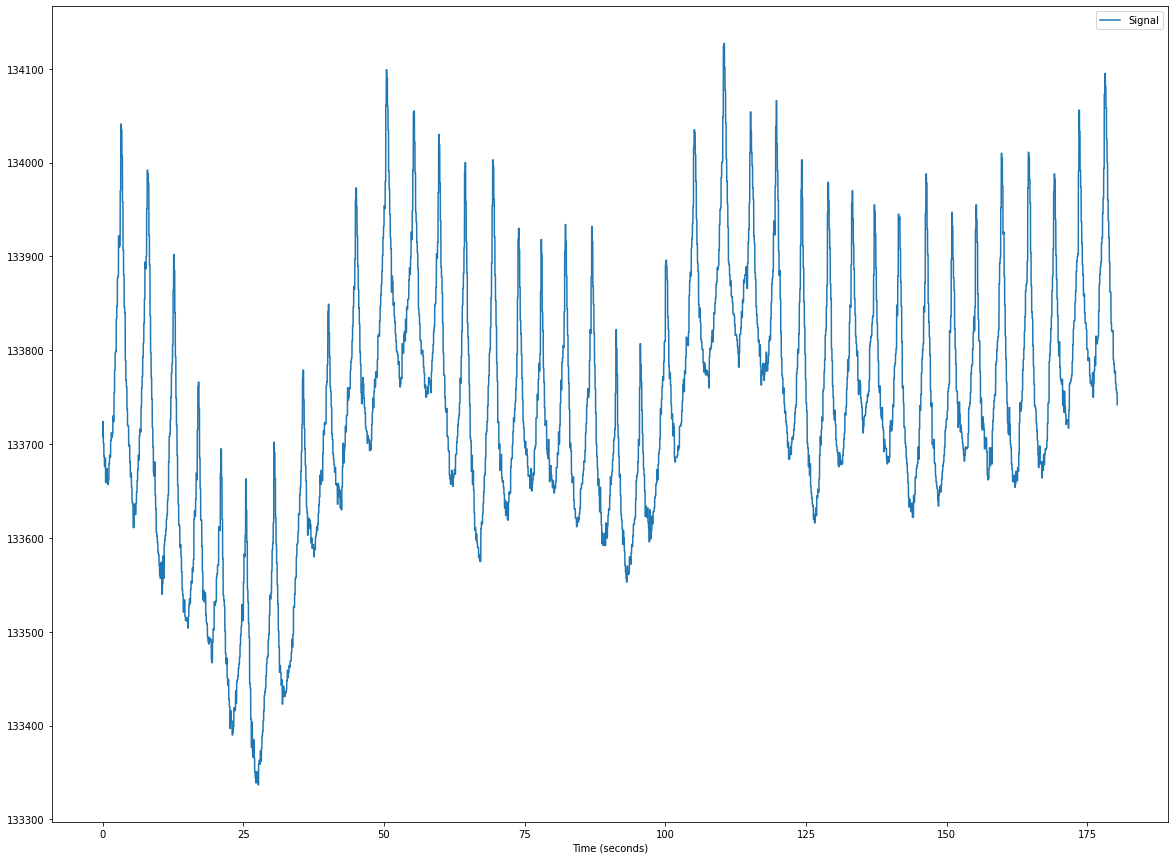

In [ ]:
nk.signal_plot(hp_ppg[2440:], standardize=False,sampling_rate=50)

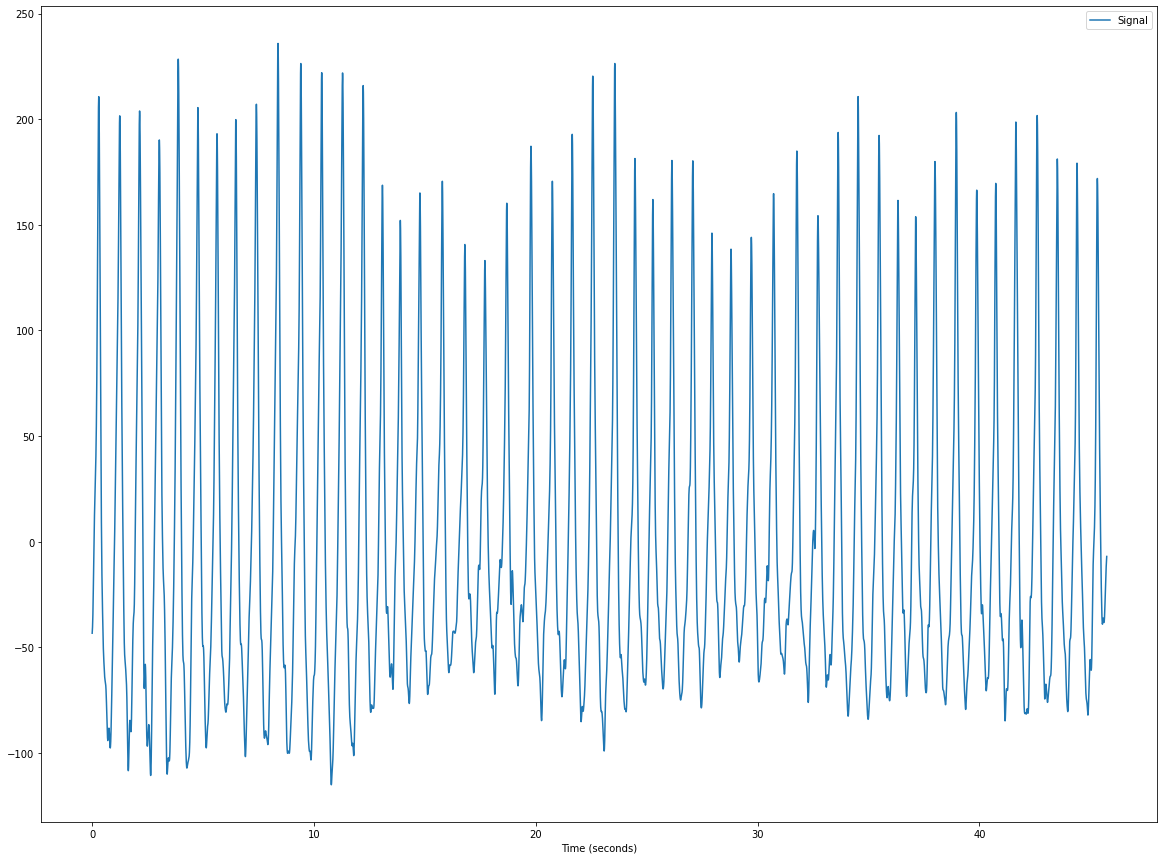

In [ ]:
filtered  = hp.filter_signal(hp_ppg[10:],cutoff=[0.8,8.5],order=2, filtertype='bandpass',sample_rate=250)
nk.signal_plot(filtered[10:], standardize=False,sampling_rate=250)


Finished in 0.035571 sec
bpm: 65.597668
ibi: 914.666667
sdnn: 66.319094
sdsd: 32.058540
rmssd: 73.824115
pnn20: 0.875000
pnn50: 0.675000
hr_mad: 40.000000
sd1: 52.056460
sd2: 72.745275
s: 11896.776163
sd1/sd2: 0.715599
breathingrate: 0.266667


<Figure size 864x432 with 0 Axes>

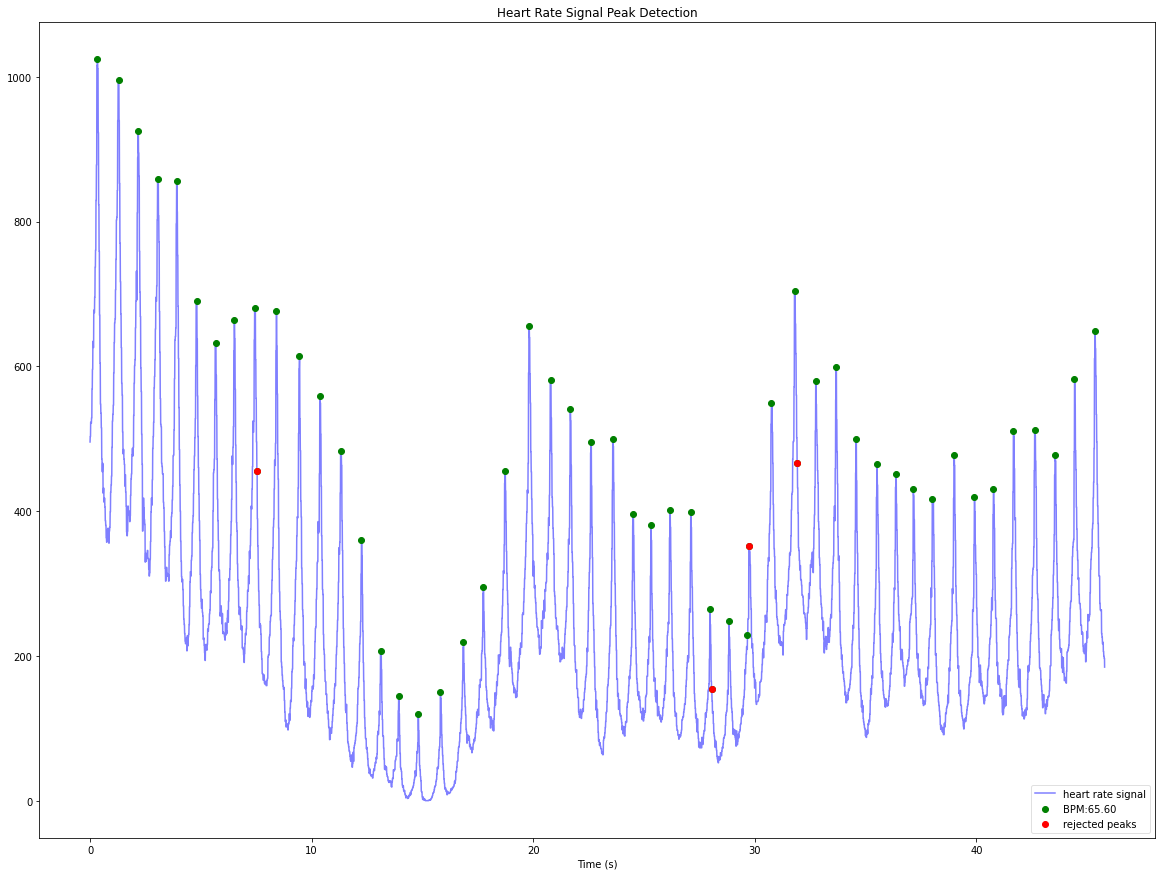

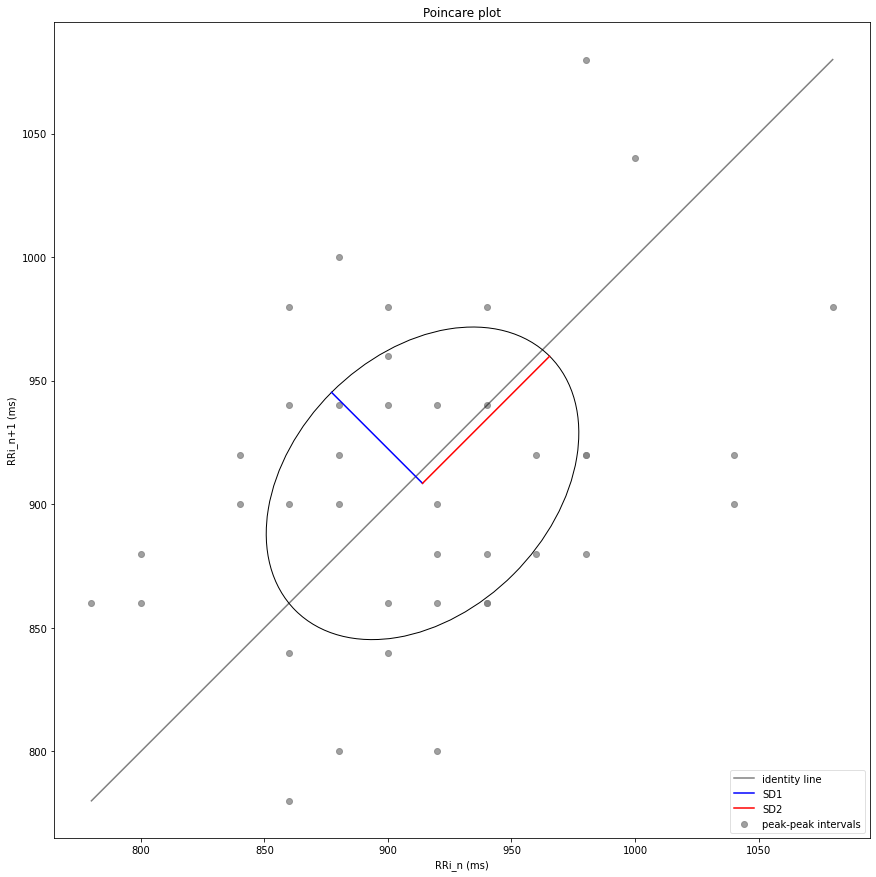

In [ ]:
enhanced = hp.enhance_peaks(hp_ppg[10:], iterations=2)

working_data, measures = hp.process(enhanced, 250, report_time=True)
plt.figure(figsize=(12,6))
hp.plotter(working_data, measures)

for key in measures.keys():
    print('%s: %f' %(key, measures[key]))
    
#and plot poincare
hp.plot_poincare(working_data, measures)

In [ ]:
print('breathing rate is: %s Hz' %measures['breathingrate'])

breathing rate is: 0.26666666666666666 Hz


In [ ]:
measures

{'bpm': 65.59766763848397,
 'breathingrate': 0.26666666666666666,
 'hr_mad': 40.0,
 'ibi': 914.6666666666666,
 'pnn20': 0.875,
 'pnn50': 0.675,
 'rmssd': 73.824115301167,
 's': 11896.776162971262,
 'sd1': 52.056459733639194,
 'sd1/sd2': 0.7155991905306559,
 'sd2': 72.7452747606331,
 'sdnn': 66.31909394904474,
 'sdsd': 32.05854020382088}

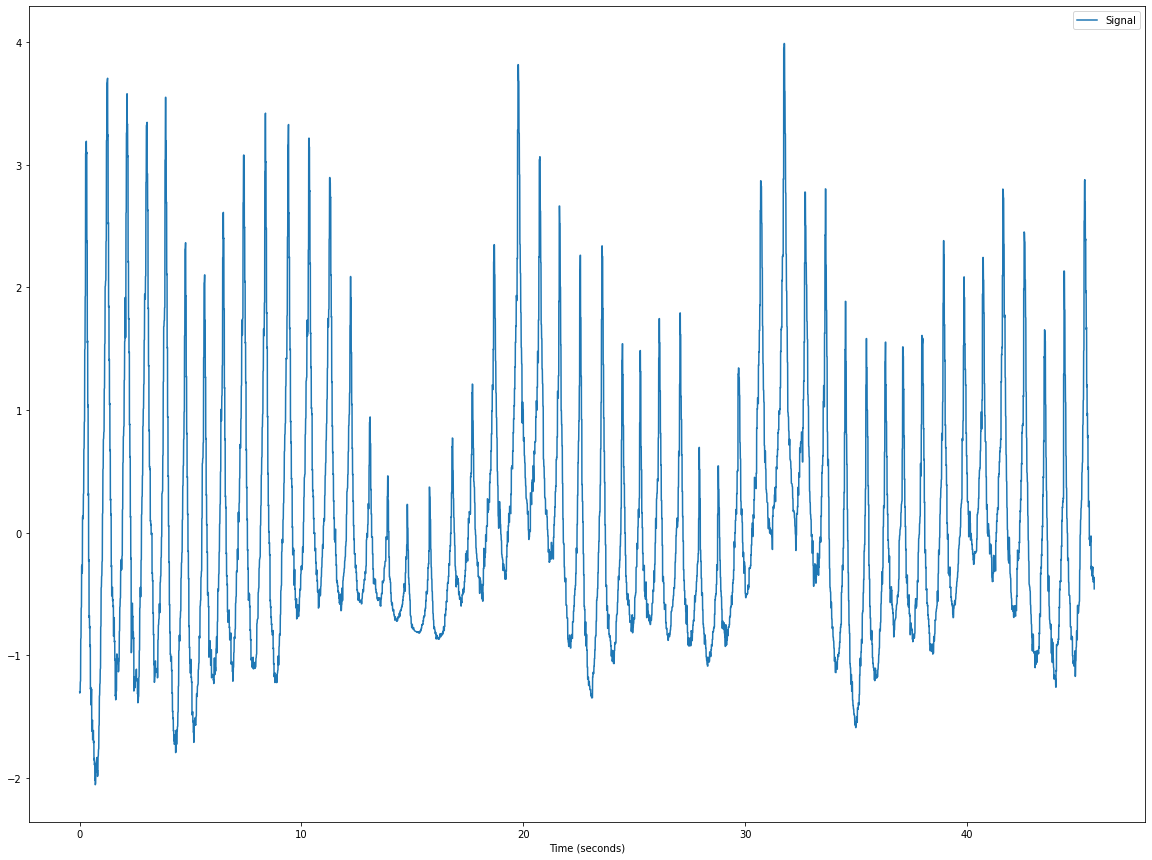

In [ ]:
ppg_signal = nk.signal_detrend(enhanced[10:], order=10)
nk.signal_plot(ppg_signal, standardize=True,sampling_rate=250)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


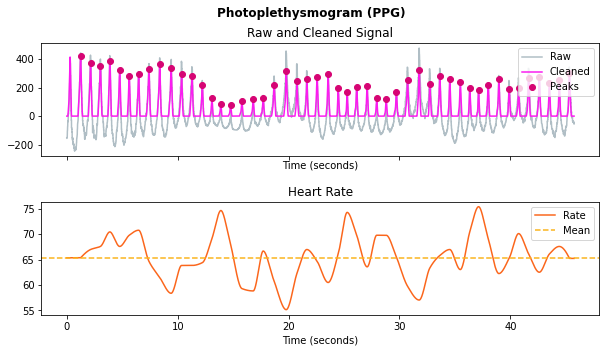

In [ ]:
signals2, info2 = nk.ppg_process(ppg_signal, sampling_rate=250)
# nk.signal_plot(signals2.PPG_Clean, sampling_rate=250)



plt.rcParams['figure.figsize'] = [10, 5]
path = '/content/drive/MyDrive/CogFlex (1)/Galea_SignalValidation/Figures/'
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'galea_ppg.eps'
fig = nk.ppg_plot(signals2, sampling_rate=250) 
fig.savefig(path+image_name, format=image_format, dpi=1200)

In [ ]:
f =signal.resample_poly(ppg_signal,250, 50)
nk.signal_plot(ppg_signal[10:1000], sampling_rate=50, standardize=True)
nk.signal_plot(f[40:10000],sampling_rate=500, standardize=True)

In [ ]:
linearPPG
# nk.signal_plot(linearPPG, standardize=True)

array([162.38489342, 231.89438038, 263.29988556, ...,  21.9121197 ,
        29.99839391,  37.93319646])

In [ ]:
quadratic_ppg = nk.signal_detrend(ppg_signal[10:], order=2)
quadratic_ppg
#nk.signal_plot(quadratic_ppg, standardize=False)

array([  17.33500912,   22.4283554 ,   22.5216867 , ..., -139.73638944,
       -139.81438393, -152.89239338])

In [ ]:
cubic_ppg = nk.signal_detrend(ppg_signal[10:], order=3)
cubic_ppg

array([-122.98058152, -117.74012822, -117.49975415, ...,    0.2850514 ,
          0.35409968,  -12.57680274])

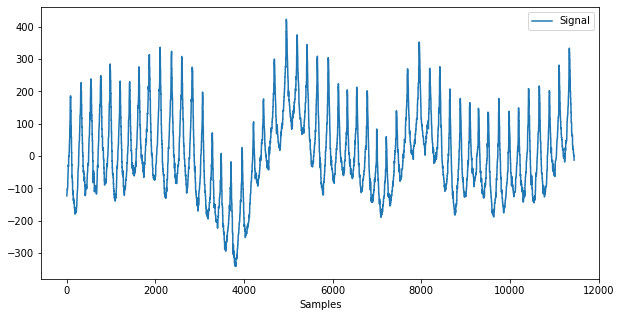

In [ ]:
nk.signal_plot(cubic_ppg, standardize=False)

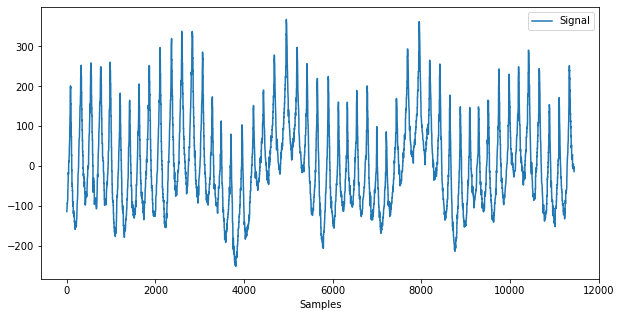

In [ ]:
poly10 = nk.signal_detrend(ppg_signal[10:], order=10)  # Linear detrend (10th order)
nk.signal_plot(poly10, standardize=False)

In [ ]:
localReg= nk.signal_detrend(f, method='locreg',window=2.5*500, stepsize=0.2*500)  # Local regression (100Hz)
ppg_clean = nk.ppg_clean(cubic_ppg)



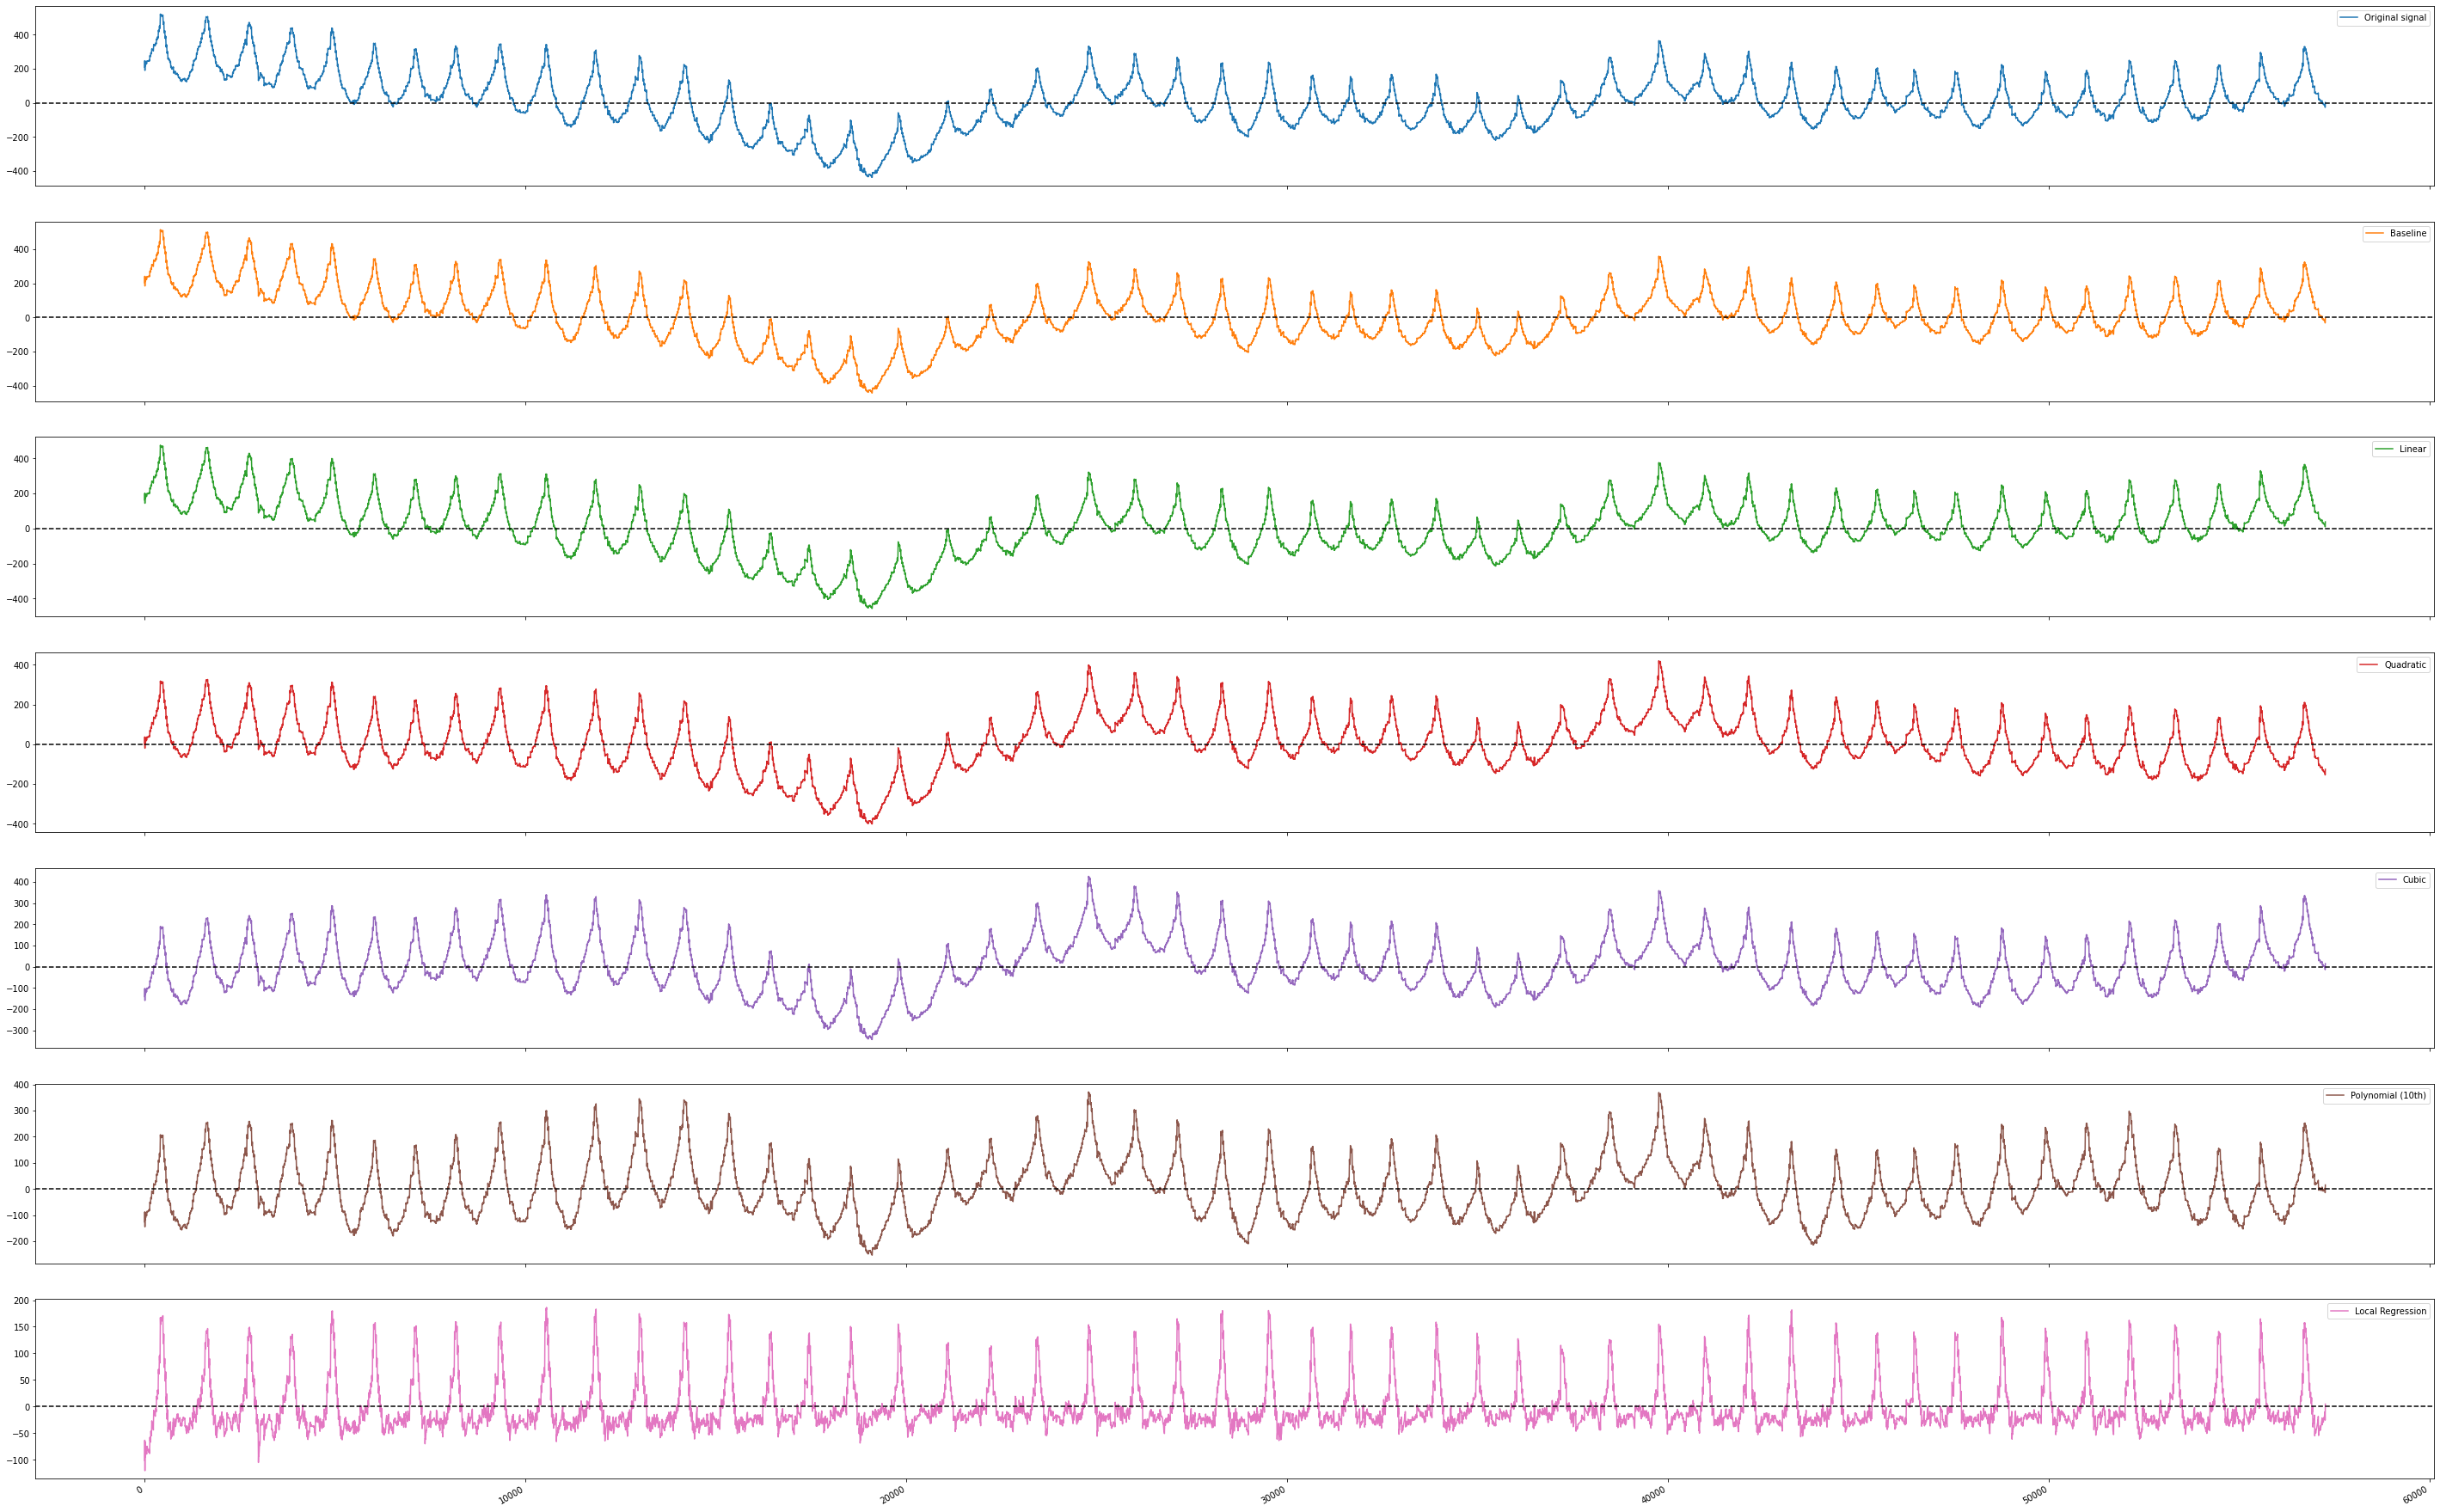

In [ ]:

plt.rcParams['figure.figsize'] = [50, 35]
 # Simulate signal with low and high frequency
signal_ppg = f[20:]
signal_ppg = signal_ppg + (3 + np.linspace(0, 6, num=len(signal_ppg)))  # Add baseline and linear trend
# Apply detrending algorithms
baseline = nk.signal_detrend(signal_ppg, order=0)  # Constant detrend (removes the mean)
linear = nk.signal_detrend(signal_ppg, order=1)  # Linear detrend
quadratic = nk.signal_detrend(signal_ppg, order=2)  # Quadratic detrend
cubic = nk.signal_detrend(signal_ppg, order=3)  # Cubic detrend
poly10 = nk.signal_detrend(signal_ppg, order=10)  # Linear detrend (10th order)
#tarvainen = nk.signal_detrend(signal_ppg, method='tarvainen2002')  # Tarvainen (2002) method
#loess = nk.signal_detrend(signal_ppg, method='loess')  # LOESS detrend (smooth removal)
locreg = nk.signal_detrend(signal_ppg, method='locreg',
                          window=1.5*500, stepsize=0.02*500)  # Local regression (100Hz)

# Visualize different methods
axes = pd.DataFrame({"Original signal": signal_ppg,
                    "Baseline": baseline,
                    "Linear": linear,
                    "Quadratic": quadratic,
                    "Cubic": cubic,
                    "Polynomial (10th)": poly10,
                    # "Tarvainen": tarvainen,
                    # "LOESS": loess,
                    "Local Regression": locreg}).plot(subplots=True)
# Plot horizontal lines to better visualize the detrending
for subplot in axes: 
    subplot.axhline(y=0, color='k', linestyle='--') 

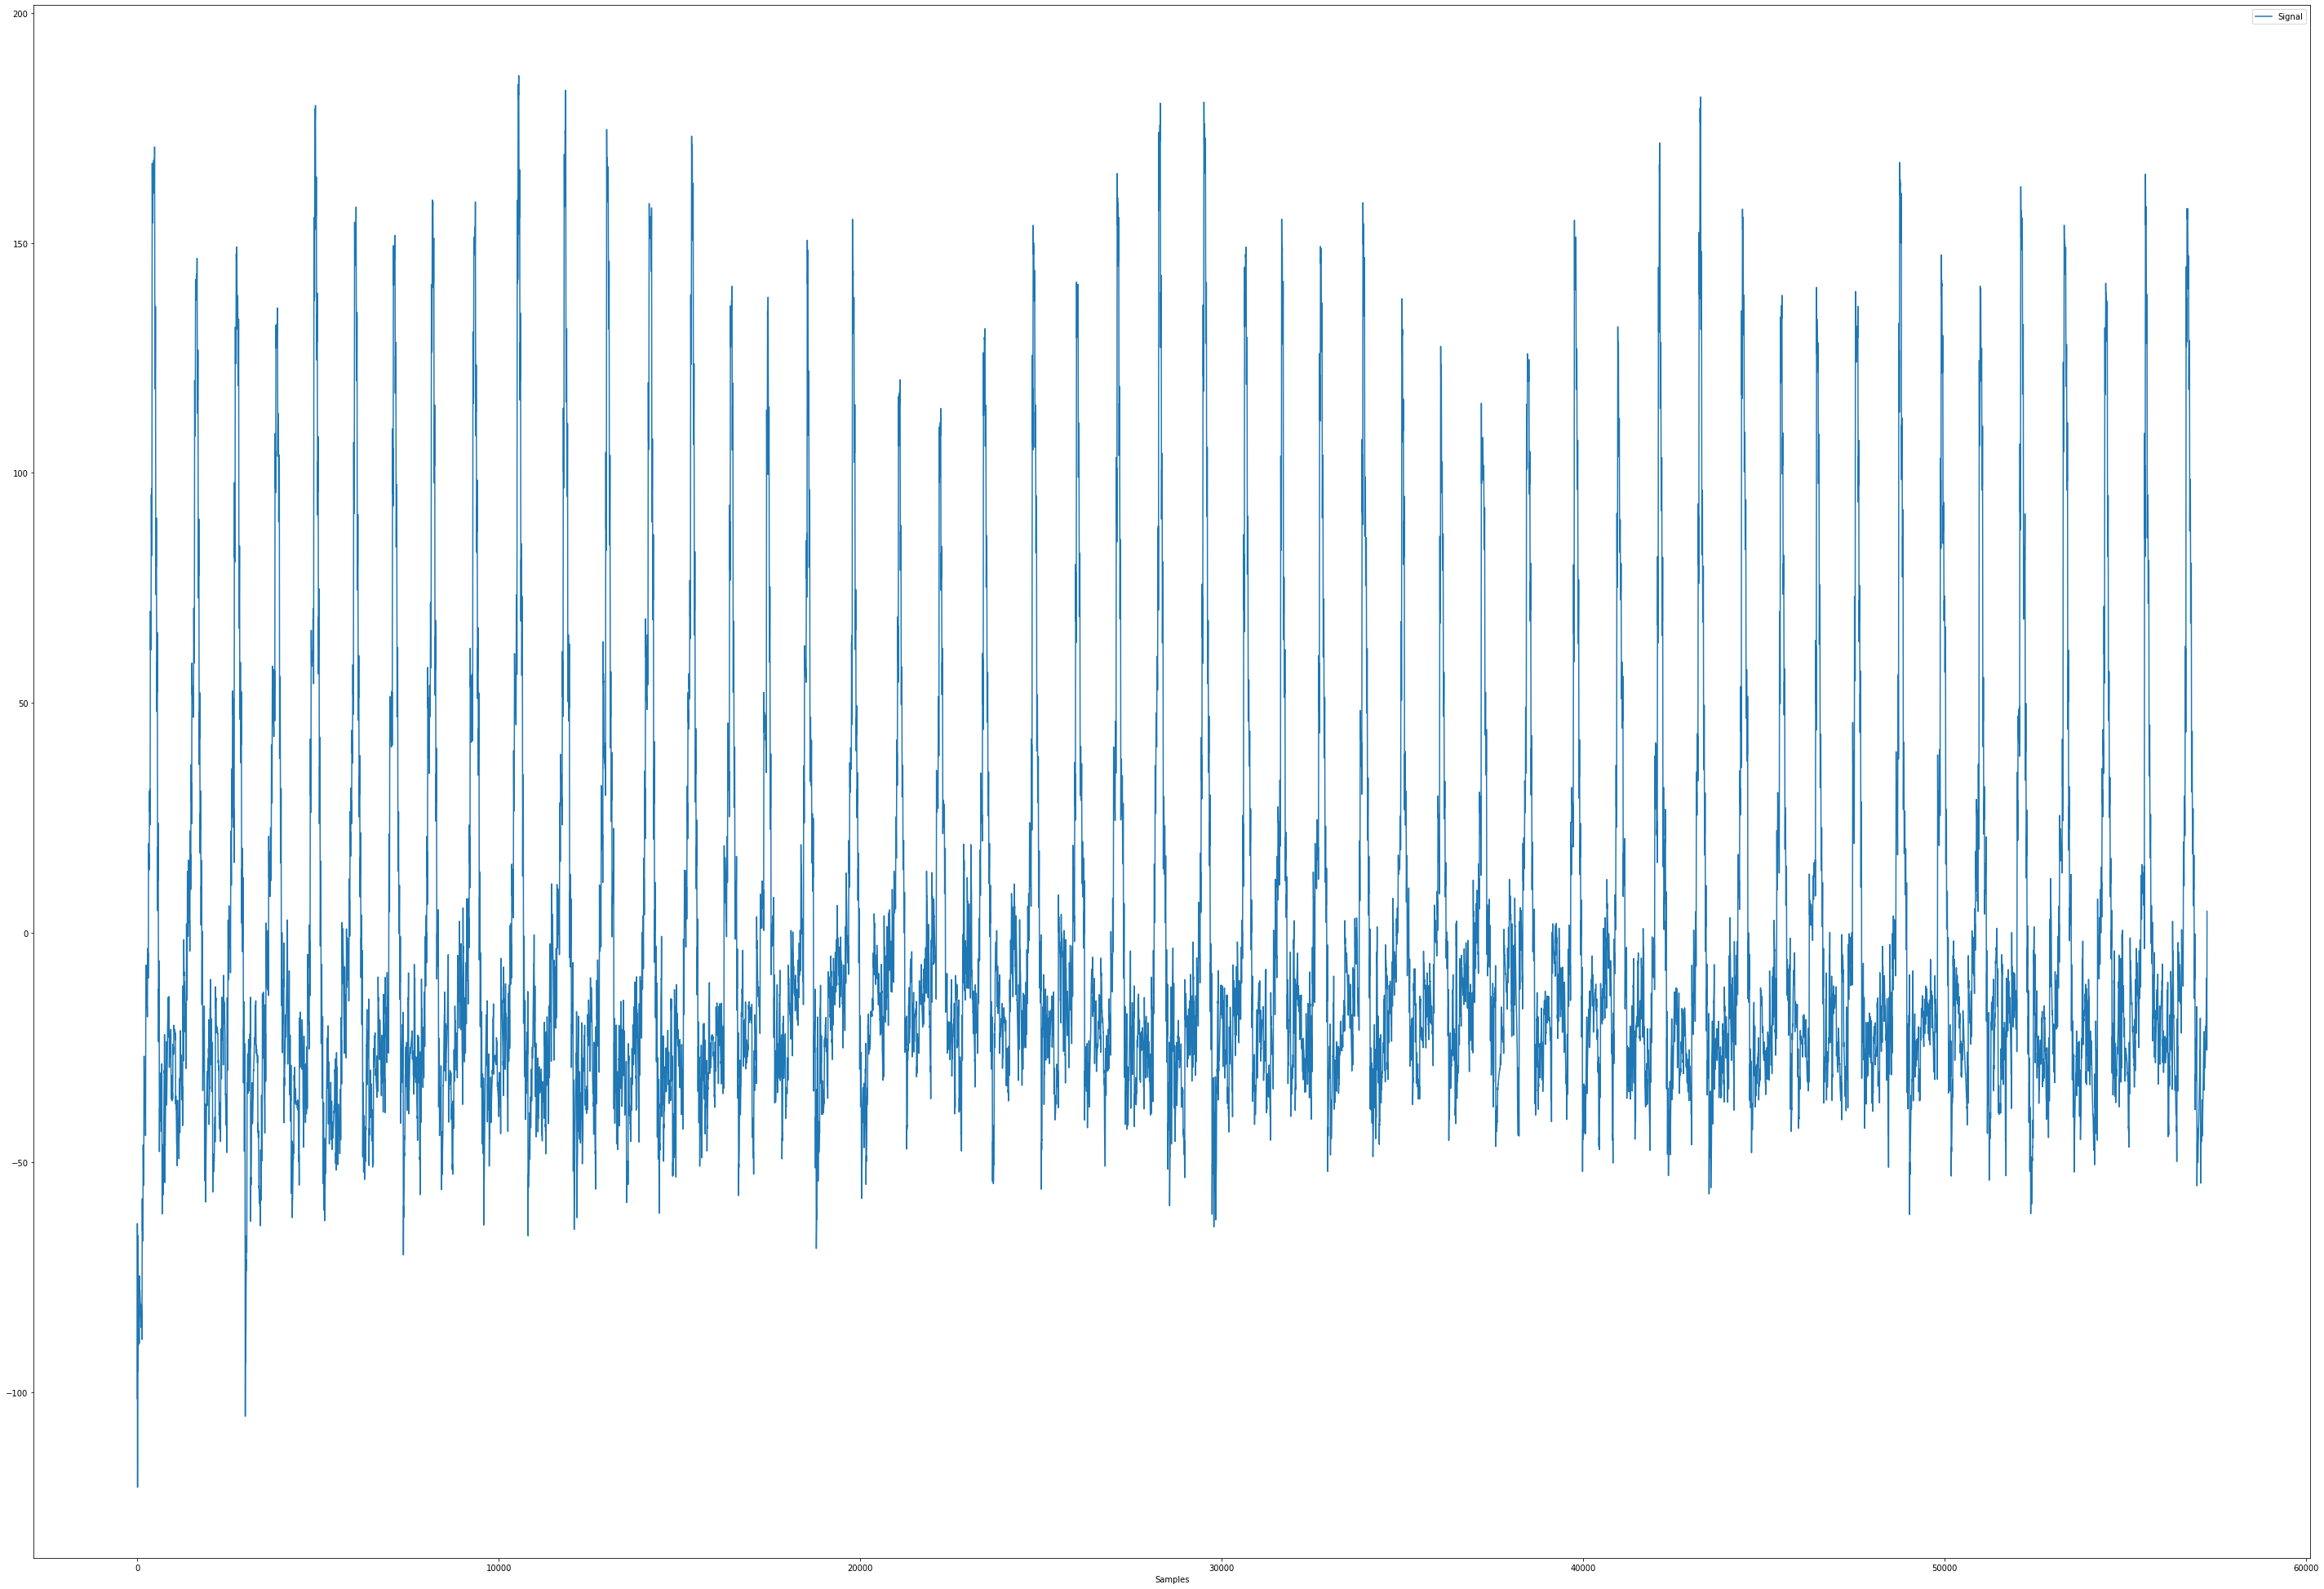

In [ ]:
clean = nk.ppg_clean(locreg, sampling_rate=100, method='nabian2018')
nk.signal_plot(clean, standardize=False)